In [1]:
!pip install sympy==1.12 -q
!pip install optuna -q


[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import optuna
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)

c:\project_resume\rul_prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names


train_df = pd.read_csv('train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
test_df = pd.read_csv('test_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
rul_df = pd.read_csv('RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])

In [5]:
max_cycles = train_df.groupby('unit_number')['time_cycles'].max().reset_index()
max_cycles.columns = ['unit_number', 'max_cycles']
train_df = pd.merge(train_df, max_cycles, on='unit_number', how='left')
train_df['RUL'] = train_df['max_cycles'] - train_df['time_cycles']
train_df.drop(columns=['max_cycles'], inplace=True)

CLIP_THRESHOLD = 125
train_df['RUL'] = train_df['RUL'].clip(upper=CLIP_THRESHOLD)
print(f"Колонка 'RUL' добавлена и обрезана по порогу {CLIP_THRESHOLD}.")

Колонка 'RUL' добавлена и обрезана по порогу 125.


In [6]:
constant_cols = ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']
cols_to_drop = setting_names + constant_cols

train_df_filtered = train_df.drop(columns=cols_to_drop)
test_df_filtered = test_df.drop(columns=cols_to_drop)

WINDOW_SIZE = 5
sensor_cols_raw = [col for col in train_df_filtered.columns if col.startswith('s_')]

for col in sensor_cols_raw:
    train_df_filtered[col + '_mean'] = train_df_filtered.groupby('unit_number')[col].rolling(WINDOW_SIZE, min_periods=1).mean().reset_index(level=0, drop=True)
    train_df_filtered[col + '_std'] = train_df_filtered.groupby('unit_number')[col].rolling(WINDOW_SIZE, min_periods=1).std().reset_index(level=0, drop=True)
    test_df_filtered[col + '_mean'] = test_df_filtered.groupby('unit_number')[col].rolling(WINDOW_SIZE, min_periods=1).mean().reset_index(level=0, drop=True)
    test_df_filtered[col + '_std'] = test_df_filtered.groupby('unit_number')[col].rolling(WINDOW_SIZE, min_periods=1).std().reset_index(level=0, drop=True)

train_df_filtered.fillna(0, inplace=True)
test_df_filtered.fillna(0, inplace=True)

feature_cols = [col for col in train_df_filtered.columns if col not in ['unit_number', 'time_cycles', 'RUL']]

scaler = RobustScaler()
train_df_filtered[feature_cols] = scaler.fit_transform(train_df_filtered[feature_cols])
test_df_filtered[feature_cols] = scaler.transform(test_df_filtered[feature_cols])

print("Созданы новые признаки и выполнена нормализация.")


Созданы новые признаки и выполнена нормализация.


In [7]:
SEQUENCE_LENGTH = 50

def create_sequences(df, sequence_length, feature_cols):
    sequences, labels = [], []
    for unit_id in df['unit_number'].unique():
        unit_data = df[df['unit_number'] == unit_id]
        rul_values = unit_data['RUL'].values
        feature_values = unit_data[feature_cols].values

        for i in range(len(unit_data) - sequence_length + 1):
            sequences.append(feature_values[i:i+sequence_length])
            labels.append(rul_values[i+sequence_length-1])

    return np.array(sequences), np.array(labels)

X_train_full, y_train_full = create_sequences(train_df_filtered, SEQUENCE_LENGTH, feature_cols)
print(f"Форма входных данных (X_train_full): {X_train_full.shape}")
print(f"Форма целевых значений (y_train_full): {y_train_full.shape}")

Форма входных данных (X_train_full): (15731, 50, 42)
Форма целевых значений (y_train_full): (15731,)


In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")


Размер обучающей выборки: (12584, 50, 42)
Размер валидационной выборки: (3147, 50, 42)


In [9]:
class TurbofanDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences).float()
        self.labels = torch.tensor(labels).float()

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = TurbofanDataset(X_train, y_train)
val_dataset = TurbofanDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [10]:
class AsymmetricMSELoss(nn.Module):
    """
    Асимметричная MSE, которая сильнее штрафует за переоценку RUL.
    """
    def __init__(self, overestimation_penalty=2.5):
        super().__init__()
        self.overestimation_penalty = overestimation_penalty

    def forward(self, y_pred, y_true):
        errors = y_pred - y_true
        penalty_weights = torch.ones_like(errors)
        penalty_weights[errors > 0] = self.overestimation_penalty
        loss = torch.mean(penalty_weights * (errors ** 2))
        return loss

In [11]:
class RUL_CNN_LSTM_Attention_v6(nn.Module):
    """
    Гибридная модель CNN-LSTM с механизмом Attention для прогнозирования RUL.
    """
    def __init__(self, input_size, dropout_prob):
        super(RUL_CNN_LSTM_Attention_v6, self).__init__()

        # Сверточный блок
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        # LSTM блок
        self.lstm = nn.LSTM(128, 128, batch_first=True, bidirectional=True, dropout=dropout_prob)

        # Attention
        self.attn_w = nn.Linear(128 * 2, 128 * 2) # *2, так как LSTM двунаправленный
        self.attn_u = nn.Linear(128 * 2, 1, bias=False)

        # Полносвязный блок
        self.fc1 = nn.Linear(128 * 2, 128)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)


    def forward(self, x):
        x = x.permute(0, 2, 1)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.maxpool(out)

        out = out.permute(0, 2, 1)
        lstm_out, _ = self.lstm(out)

        u = torch.tanh(self.attn_w(lstm_out))
        attn_scores = self.attn_u(u).squeeze(2)
        attn_weights = torch.softmax(attn_scores, dim=1).unsqueeze(2)

        context_vector = torch.sum(lstm_out * attn_weights, dim=1)

        out = self.dropout(self.relu(self.fc1(context_vector)))
        out = self.dropout(self.relu(self.fc2(out)))
        out = self.fc3(out)

        return out

In [13]:
LEARNING_RATE = 0.00088
DROPOUT_PROB = 0.103
NUM_EPOCHS = 30
BATCH_SIZE = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = X_train.shape[2]

model = RUL_CNN_LSTM_Attention_v6(INPUT_SIZE, DROPOUT_PROB).to(device)
criterion = AsymmetricMSELoss(overestimation_penalty=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

print(f"Начинаем обучение модели на устройстве: {device}")
print(f"Параметры: LR={LEARNING_RATE}, Dropout={DROPOUT_PROB}, Эпох={NUM_EPOCHS}")

history = {'train_rmse': [], 'val_rmse': []}

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item()

    avg_train_loss = np.sqrt(train_loss / len(train_loader))
    avg_val_loss = np.sqrt(val_loss / len(val_loader))
    
    history['train_rmse'].append(avg_train_loss)
    history['val_rmse'].append(avg_val_loss)

    print(f"Эпоха {epoch+1}/{NUM_EPOCHS}, Train RMSE: {avg_train_loss:.4f}, Val RMSE: {avg_val_loss:.4f}")

    scheduler.step(avg_val_loss)

print("\nОбучение завершено.")

Начинаем обучение модели на устройстве: cpu
Параметры: LR=0.00088, Dropout=0.103, Эпох=30
Эпоха 1/30, Train RMSE: 37.1169, Val RMSE: 17.9101
Эпоха 2/30, Train RMSE: 17.5572, Val RMSE: 13.4173
Эпоха 3/30, Train RMSE: 15.4809, Val RMSE: 13.5364
Эпоха 4/30, Train RMSE: 13.6014, Val RMSE: 13.4015
Эпоха 5/30, Train RMSE: 12.1983, Val RMSE: 10.1191
Эпоха 6/30, Train RMSE: 11.5893, Val RMSE: 10.3101
Эпоха 7/30, Train RMSE: 10.8818, Val RMSE: 7.3586
Эпоха 8/30, Train RMSE: 10.7997, Val RMSE: 7.1270
Эпоха 9/30, Train RMSE: 10.5141, Val RMSE: 6.7152
Эпоха 10/30, Train RMSE: 10.0031, Val RMSE: 6.2941
Эпоха 11/30, Train RMSE: 9.6544, Val RMSE: 5.6365
Эпоха 12/30, Train RMSE: 9.8314, Val RMSE: 5.4383
Эпоха 13/30, Train RMSE: 9.2466, Val RMSE: 5.5831
Эпоха 14/30, Train RMSE: 9.3106, Val RMSE: 7.3430
Эпоха 15/30, Train RMSE: 9.2876, Val RMSE: 6.6086
Эпоха 16/30, Train RMSE: 9.1726, Val RMSE: 6.8236
Эпоха 17/30, Train RMSE: 9.0077, Val RMSE: 4.6873
Эпоха 18/30, Train RMSE: 8.7681, Val RMSE: 5.8515
Эпо

In [14]:
X_test_list = []
for unit_id in test_df_filtered['unit_number'].unique():
    unit_data = test_df_filtered[test_df_filtered['unit_number'] == unit_id]
    sensor_values = unit_data[feature_cols].values
    last_cycles_data = sensor_values[-SEQUENCE_LENGTH:] # Берем последние 30 (или меньше) записей
    X_test_list.append(last_cycles_data)

X_test_np = pad_sequences(X_test_list, maxlen=SEQUENCE_LENGTH, dtype='float32', padding='pre')
X_test_tensor = torch.tensor(X_test_np).float().to(device)

model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

y_pred = y_pred_tensor.cpu().numpy().flatten()
y_true = rul_df['RUL'].values.clip(max=CLIP_THRESHOLD) 

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"\nИтоговый RMSE на тестовых данных: {rmse:.2f} циклов")


Итоговый RMSE на тестовых данных: 14.28 циклов


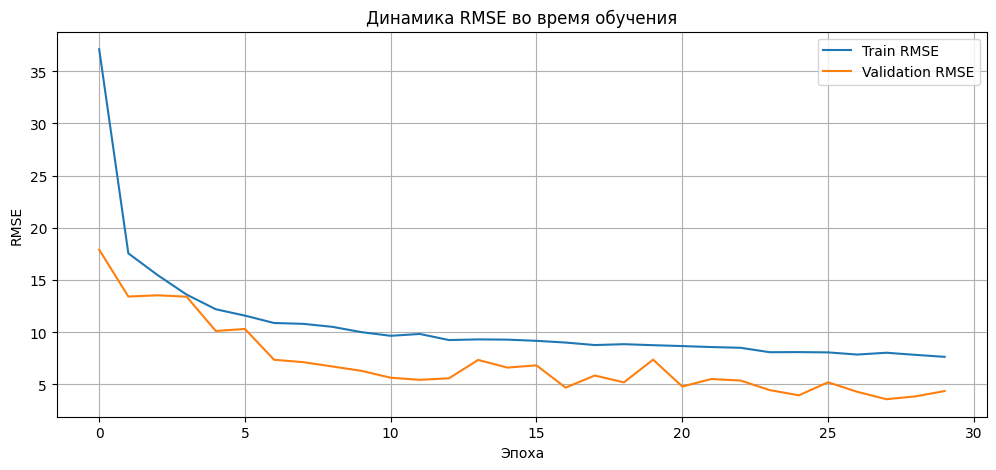

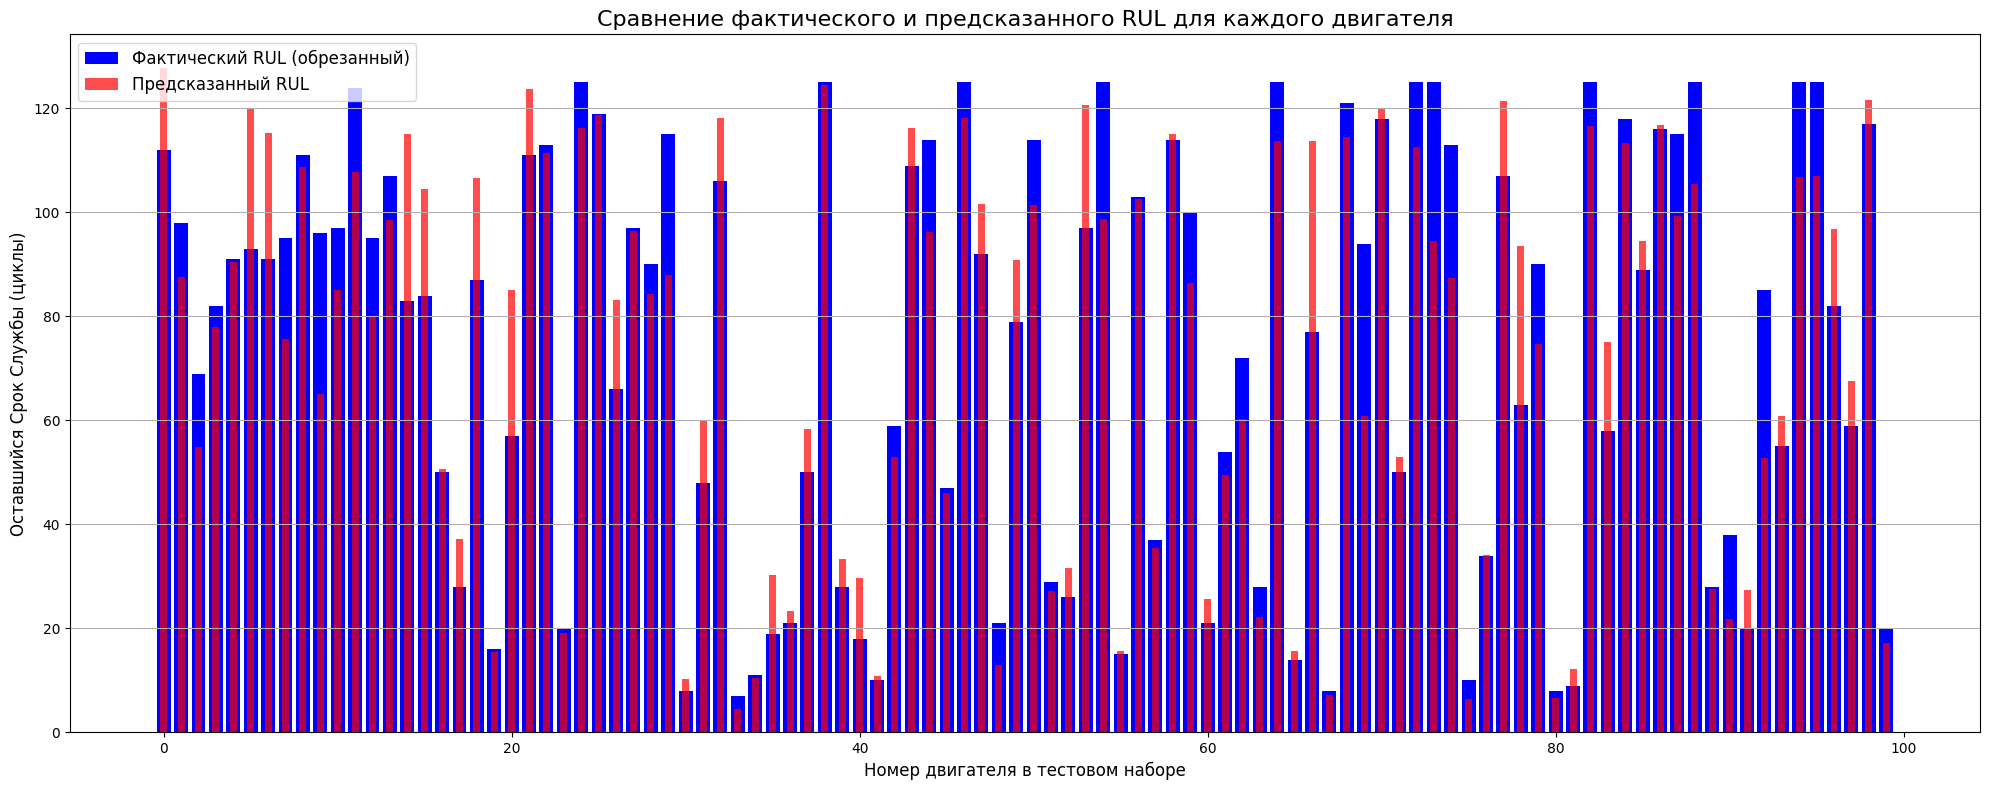

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(history['train_rmse'], label='Train RMSE')
plt.plot(history['val_rmse'], label='Validation RMSE')
plt.title('Динамика RMSE во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 8))
indices = np.arange(len(y_true))
bar_width = 0.8
plt.bar(indices, y_true, width=bar_width, color='blue', label='Фактический RUL (обрезанный)')
plt.bar(indices, y_pred, width=bar_width * 0.5, color='red', alpha=0.7, label='Предсказанный RUL')
plt.title('Сравнение фактического и предсказанного RUL для каждого двигателя', fontsize=16)
plt.xlabel('Номер двигателя в тестовом наборе', fontsize=12)
plt.ylabel('Оставшийся Срок Службы (циклы)', fontsize=12)
plt.legend(prop={'size': 12})
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()